In [ ]:
import numpy as np
import pandas as pd
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, df, input_window=14, output_window=14, target_col_name='transaction_count'):
        """
        df               : A pandas DataFrame that includes both features and the target column.
        input_window     : Number of time steps used as input (lookback).
        output_window    : Number of time steps to forecast (e.g. 14 for 14-day).
        target_col_name  : Name of the target column in df.
        """
        # Separate the features vs. target
        self.X_data = df.values  # all columns except target
        self.y_data = df[target_col_name].values               

        self.input_window = input_window
        self.output_window = output_window

    def __len__(self):
        # The maximum valid index is total_rows - (input_window + output_window)
        return len(self.X_data) - (self.input_window + self.output_window - 1)

    def __getitem__(self, idx):
        # 1) Slice out the input window
        x_start = idx
        x_end   = idx + self.input_window
        X = self.X_data[x_start : x_end]   # shape => (input_window, num_features)

        # 2) Slice out the next 'output_window' points of the target
        y_start = x_end
        y_end   = x_end + self.output_window
        Y = self.y_data[y_start : y_end]   # shape => (output_window,)

        # Convert to float32 for PyTorch
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)
        return X, Y


In [ ]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              stride=1, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # optional
        # You could add WeightNorm, layernorm, etc.
        
    def forward(self, x):
        """
        x shape: [batch_size, channels, seq_len]
        """
        out = self.conv(x)
        # Remove extra time-steps from padding to maintain causality
        out = out[:, :, :-self.conv.padding[0]]  # remove the last "padding" points
        out = self.relu(out)
        out = self.dropout(out)
        return out
    
class TCN(nn.Module):
    def __init__(self, in_channels, channel_list, kernel_size=3, dropout=0.2):
        super().__init__()
        blocks = []
        current_in = in_channels
        for i, out_ch in enumerate(channel_list):
            dilation = 2 ** i
            block = TCNBlock(current_in, out_ch, kernel_size, dilation=dilation)
            blocks.append(block)
            current_in = out_ch
        self.network = nn.Sequential(*blocks)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.network(x)
        x = self.dropout(x)
        return x

    
class TCNForecastingModel(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2, output_size=14):
        super(TCNForecastingModel, self).__init__()
        self.tcn = TCN(num_inputs, num_channels, kernel_size, dropout)
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        y = self.tcn(x)
        y = y[:, :, -1]
        return self.fc(y)


### Load and prepare data

In [3]:
# Load data
import os

os.chdir("/Users/megan/Thesis/")
print("Current working directory:", os.getcwd())
data = pd.read_csv('data/top_800_product_groups.csv')
data['date'] = pd.to_datetime(data['date'], errors='coerce')

Current working directory: /Users/megan/Thesis


In [4]:
data["day_of_week"] = data["date"].dt.dayofweek 
data["day_of_month"] = data["date"].dt.day
data["month"] = data["date"].dt.month
data["day_of_year"] = data["date"].dt.dayofyear
data["year"] = data["date"].dt.year

# Define numerical columns (exclude 'product_group' and 'date')
numerical_columns = [
    'transaction_count',
    'avg_price',
    'unique_customers',
    'unique_articles_sold',
    'median_age',
    'fashion_news_subscribers',
    'first_purchase_days_ago',
    'recent_purchase_days_ago',
    'day_of_week',
    'day_of_month',
    'month',
    'day_of_year',
    'year'
]

categorical_columns = [
    'sales_channel_2',
    'most_common_age_bin_20-29',
    'most_common_age_bin_30-39',
    'most_common_age_bin_40-49',
    'most_common_age_bin_50-59',
    'most_common_age_bin_60+'
]

In [45]:
top_10_groups = [
    "Bra Black Solid",
    "Dress Black Solid",
    "Leggings/Tights Black Solid",
    "Sweater Black Solid",
    "T-shirt Black Solid",
    "T-shirt White Solid",
    "Top Black Solid",
    "Trousers Black Solid",
    "Trousers Blue Denim",
    "Vest top Black Solid"
]


In [5]:
categorical_columns = [
    'sales_channel_2', 'most_common_age_bin_20-29', 'most_common_age_bin_30-39',
    'most_common_age_bin_40-49', 'most_common_age_bin_50-59', 'most_common_age_bin_60+'
]

# One-hot encode the categorical columns
data = pd.get_dummies(data, columns=categorical_columns, dtype=int)

In [6]:
data.drop(columns=['std_price', 'club_member_ratio'], inplace=True)

In [27]:
data.dtypes

date                           datetime64[ns]
product_group                          object
transaction_count                       int64
avg_price                             float64
unique_customers                        int64
unique_articles_sold                    int64
median_age                            float64
fashion_news_subscribers                int64
first_purchase_days_ago                 int64
recent_purchase_days_ago                int64
day_of_week                             int32
day_of_month                            int32
month                                   int32
day_of_year                             int32
year                                    int32
sales_channel_2_0                       int64
sales_channel_2_1                       int64
most_common_age_bin_20-29_0             int64
most_common_age_bin_20-29_1             int64
most_common_age_bin_30-39_0             int64
most_common_age_bin_30-39_1             int64
most_common_age_bin_40-49_0       

### Pretraining

In [ ]:
pretrain_data = data[~data['product_group'].isin(top_10_groups)].copy()
top10_data = data[data['product_group'].isin(top_10_groups)].copy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Sort by date and drop non-numeric columns
pretrain_data.sort_values(["date", "product_group"], inplace=True)
pretrain_data = pretrain_data.drop(columns=['date', 'product_group'])

# Separate features and target
X_pretrain = pretrain_data.drop(columns=['transaction_count']).values
y_pretrain = pretrain_data['transaction_count'].values.reshape(-1, 1)

# Fit scalers on the pretraining data
feature_scaler = MinMaxScaler()
X_pretrain_scaled = feature_scaler.fit_transform(X_pretrain)

target_scaler = MinMaxScaler()
y_pretrain_scaled = target_scaler.fit_transform(y_pretrain)

# Rebuild a scaled DataFrame
pretrain_df_scaled = pd.DataFrame(
    X_pretrain_scaled, 
    columns=[col for col in pretrain_data.columns if col != 'transaction_count']
)
pretrain_df_scaled['transaction_count'] = y_pretrain_scaled

# Create a TimeSeriesDataset
train_dataset = TimeSeriesDataset(
    pretrain_df_scaled, 
    input_window=14, 
    output_window=1, 
    target_col_name='transaction_count'
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        """
        A 1D convolution that pads only on the left to ensure causality.
        """
        super(CausalConv1d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        # No padding here; we will pad manually in forward.
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=0, dilation=dilation)
        
    def forward(self, x):
        # Calculate the required left padding: (kernel_size-1) * dilation
        pad = (self.kernel_size - 1) * self.dilation
        # Pad only on the left: (left, right)
        x = F.pad(x, (pad, 0))
        return self.conv(x)

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Use CausalConv1d instead of regular Conv1d with symmetric padding.
        self.conv1 = CausalConv1d(in_channels, out_channels, kernel_size, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = CausalConv1d(out_channels, out_channels, kernel_size, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.net = nn.Sequential(
            self.conv1, self.relu1, self.dropout1,
            self.conv2, self.relu2, self.dropout2
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
                          if in_channels != out_channels else None
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        """
        num_channels: list of output channels for each TemporalBlock.
        """
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_channels = num_inputs if i == 0 else num_channels[i]
            out_channels = num_channels[i]
            dilation_size = 2 ** i  # increasing dilation for deeper layers
            layers.append(
                TemporalBlock(in_channels, out_channels, kernel_size,
                              dilation=dilation_size, dropout=dropout)
            )
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class TCNForecastingModel(nn.Module):
    def __init__(
        self,
        num_inputs,
        num_channels,
        kernel_size=2,
        dropout=0.2,
        output_size=14, 
    ):
        super().__init__()
        self.tcn = TCN(num_inputs, num_channels, kernel_size, dropout)
        # Final linear layer maps from the last layer’s hidden size to output_size
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        # x shape: (batch_size, input_window, num_inputs)
        # Permute to (batch_size, num_inputs, input_window) for Conv1d
        x = x.permute(0, 2, 1)
        y = self.tcn(x)            # shape => (batch_size, num_channels[-1], seq_len)
        y = y[:, :, -1]            # take the last time step: shape => (batch_size, num_channels[-1])
        out = self.fc(y)           # shape => (batch_size, output_size=14)
        return out

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm  

source_df_scaled = pretrain_df_scaled

# Create the dataset using the scaled data
train_dataset = TimeSeriesDataset(source_df_scaled, input_window=14, output_window=1, target_col_name='transaction_count')

# Split the dataset into training and validation sets sequentially.
val_ratio = 0.2  
num_samples = len(train_dataset)
num_train = int(num_samples * (1 - val_ratio))
num_val = num_samples - num_train

train_subset = Subset(train_dataset, list(range(num_train)))
val_subset = Subset(train_dataset, list(range(num_train, num_samples)))

train_loader = DataLoader(train_subset, batch_size=32, shuffle=False)  # No shuffle for time-series
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Set the number of features from the scaled DataFrame
num_features = source_df_scaled.shape[1]  # Make sure this matches your inputs

# Define hyperparameters for the TCN.
num_channels = [64, 64]    
kernel_size = 3         
dropout = 0.2

# Initialize the TCN forecasting model
model = TCNForecastingModel(num_inputs=num_features, num_channels=num_channels, kernel_size=kernel_size, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Pretrain the model on all product groups (source domain)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_epoch_loss = 0.0
    
    # Training loop with progress bar.
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    
    avg_train_loss = train_epoch_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_epoch_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_epoch_loss += loss.item()
    avg_val_loss = val_epoch_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

# Save the pretrained model's weights.
torch.save(model.state_dict(), "pretrained_tcn.pt")
print("Pretraining completed and model weights saved.")


Epoch 1/30 - Train Loss: 0.000576 - Val Loss: 0.000666


Epoch 2/30 - Train Loss: 0.000519 - Val Loss: 0.000571


Epoch 3/30 - Train Loss: 0.000513 - Val Loss: 0.000570


Epoch 4/30 - Train Loss: 0.000507 - Val Loss: 0.000566


Epoch 5/30 - Train Loss: 0.000503 - Val Loss: 0.000568


Epoch 6/30 - Train Loss: 0.000500 - Val Loss: 0.000564


Epoch 7/30 - Train Loss: 0.000495 - Val Loss: 0.000559


Epoch 8/30 - Train Loss: 0.000491 - Val Loss: 0.000555


Epoch 9/30 - Train Loss: 0.000487 - Val Loss: 0.000557


Epoch 10/30 - Train Loss: 0.000483 - Val Loss: 0.000551


Epoch 11/30 - Train Loss: 0.000478 - Val Loss: 0.000553


Epoch 12/30 - Train Loss: 0.000474 - Val Loss: 0.000545


Epoch 13/30 - Train Loss: 0.000467 - Val Loss: 0.000535


Epoch 14/30 - Train Loss: 0.000463 - Val Loss: 0.000538


Epoch 15/30 - Train Loss: 0.000458 - Val Loss: 0.000539


Epoch 16/30 - Train Loss: 0.000456 - Val Loss: 0.000531


Epoch 17/30 - Train Loss: 0.000451 - Val Loss: 0.000532


Epoch 18/30 - Train Loss: 0.000449 - Val Loss: 0.000529


Epoch 19/30 - Train Loss: 0.000446 - Val Loss: 0.000528


Epoch 20/30 - Train Loss: 0.000443 - Val Loss: 0.000514


Epoch 21/30 - Train Loss: 0.000440 - Val Loss: 0.000509


Epoch 22/30 - Train Loss: 0.000432 - Val Loss: 0.000504


Epoch 23/30 - Train Loss: 0.000429 - Val Loss: 0.000505


Epoch 24/30 - Train Loss: 0.000424 - Val Loss: 0.000510


Epoch 25/30 - Train Loss: 0.000419 - Val Loss: 0.000504


Epoch 26/30 - Train Loss: 0.000416 - Val Loss: 0.000502


Epoch 27/30 - Train Loss: 0.000408 - Val Loss: 0.000505


Epoch 28/30 - Train Loss: 0.000403 - Val Loss: 0.000506


Epoch 29/30 - Train Loss: 0.000398 - Val Loss: 0.000490


Epoch 30/30 - Train Loss: 0.000391 - Val Loss: 0.000497
Pretraining completed and model weights saved.


### Fine-tuning

In [61]:
# Filter out top 10 data
top10_data = data[data['product_group'].isin(top_10_groups)].copy()

# Drop non-numeric columns (date, product_group) if not used
top10_data = top10_data.drop(columns=['date', 'product_group'])

# Separate features/target
X_top10 = top10_data.drop(columns=['transaction_count']).values
y_top10 = top10_data['transaction_count'].values.reshape(-1, 1)

# Apply the same scalers used during pretraining (or fit new ones, if desired)
X_top10_scaled = feature_scaler.transform(X_top10)    # transform, not fit_transform
y_top10_scaled = target_scaler.transform(y_top10)

# Build a new DataFrame with scaled data
top10_df_scaled = pd.DataFrame(
    X_top10_scaled, 
    columns=[col for col in top10_data.columns if col != 'transaction_count']
)
top10_df_scaled['transaction_count'] = y_top10_scaled

# Sort by time if needed (assuming your index or a separate 'date' column)
top10_df_scaled = top10_df_scaled.sort_index()

input_window = 14
output_window = 1
target_col_name = 'transaction_count'

top10_dataset = TimeSeriesDataset(
    top10_df_scaled,
    input_window=input_window,
    output_window=output_window,
    target_col_name=target_col_name
)

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from modules.utils import process_name

all_groups_results = {}

output_dir = "output/top_10_product_groups/transfer"
os.makedirs(output_dir, exist_ok=True)

for product_group in top_10_groups:
    print(f"\n=== Running for {product_group} ===")
    
    # 1. Filter data
    group_df = data[data['product_group'] == product_group].copy()
    
    # Drop non-numeric columns
    group_df = group_df.drop(columns=['date','product_group'])
    
    # Scale
    X_group = group_df.drop(columns=['transaction_count']).values
    y_group = group_df['transaction_count'].values.reshape(-1,1)
    X_group_scaled = feature_scaler.transform(X_group)
    y_group_scaled = target_scaler.transform(y_group)
    
    group_df_scaled = pd.DataFrame(
        X_group_scaled,
        columns=[col for col in group_df.columns if col != 'transaction_count']
    )
    group_df_scaled['transaction_count'] = y_group_scaled
    group_df_scaled = group_df_scaled.sort_index()
    
    # Create dataset
    input_window = 14
    output_window = 1
    target_col_name = 'transaction_count'
    
    group_dataset = TimeSeriesDataset(
        group_df_scaled,
        input_window=input_window,
        output_window=output_window,
        target_col_name=target_col_name
    )
    
    # Prepare for cross-validation
    tscv = TimeSeriesSplit(n_splits=4)
    fold_metrics = []
    
    # Create figure
    fig, axes = plt.subplots(nrows=tscv.n_splits, ncols=2, figsize=(20, 5 * tscv.n_splits))
    fig.suptitle(f"{product_group}: Predictions vs Actual & Residuals", fontsize=16, y=0.95)

    fold = 0
    for train_idx, val_idx in tscv.split(np.arange(len(group_dataset))):
        fold += 1
        print(f"=== Fold {fold} ===")
        
        train_subset = Subset(group_dataset, train_idx)
        val_subset = Subset(group_dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=False)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
        
        # Initialize model
        num_features = source_df_scaled.shape[1] 
        model = TCNForecastingModel(
            num_inputs=num_features,
            num_channels=[64, 64],
            kernel_size=3,
            dropout=0.2
        )
        
        checkpoint = torch.load("pretrained_tcn.pt")
        model_dict = model.state_dict()

        # Only remove the final layer keys if their shapes do not match.
        if "fc.weight" in checkpoint:
            if checkpoint["fc.weight"].shape != model_dict["fc.weight"].shape:
                checkpoint.pop("fc.weight", None)
                checkpoint.pop("fc.bias", None)

        # Load the checkpoint with strict=False so that any remaining mismatches are ignored.
        model.load_state_dict(checkpoint, strict=False)

        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        
        epochs = 30
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            avg_train_loss = train_loss / len(train_loader)
            
            # Evaluate on validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    preds = model(X_batch)
                    loss = criterion(preds, y_batch)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            
            if (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        
        # Collect predictions on val set
        all_preds, all_targets = [], []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds = model(X_batch)
                all_preds.append(preds.cpu().numpy())
                all_targets.append(y_batch.cpu().numpy())
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        
        # Compute metrics
        mae = mean_absolute_error(all_targets, all_preds)
        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        mape = np.mean(np.abs((all_targets - all_preds) / np.maximum(np.abs(all_targets), 1e-8))) * 100
        r2 = r2_score(all_targets, all_preds)
        
        print(f"Fold {fold} => MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")
        fold_metrics.append({
            'Fold': fold,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2
        })
        
        # Plot predictions vs. actual
        ax_pred = axes[fold-1, 0] if tscv.n_splits > 1 else axes[0]
        ax_res = axes[fold-1, 1] if tscv.n_splits > 1 else axes[1]
        
        val_x = np.arange(len(all_preds))  # or use a date index if you have one
        ax_pred.plot(val_x, all_targets, label="Actual", alpha=0.7)
        ax_pred.plot(val_x, all_preds, label="Predicted", alpha=0.7, linestyle='--')
        ax_pred.set_title(f"Fold {fold}: Predictions vs Actual")
        ax_pred.legend()
        
        # Residuals
        residuals = all_targets - all_preds
        ax_res.plot(val_x, residuals, label="Residuals")
        ax_res.axhline(0, color='r', linestyle='--', alpha=0.5)
        ax_res.set_title(f"Fold {fold}: Residuals")
        ax_res.legend()
    
    # Summarize fold metrics
    fold_metrics_df = pd.DataFrame(fold_metrics)
    avg_metrics = {
        'MAE': fold_metrics_df['MAE'].mean(),
        'RMSE': fold_metrics_df['RMSE'].mean(),
        'MAPE': fold_metrics_df['MAPE'].mean(),
        'R2': fold_metrics_df['R2'].mean()
    }
    print(f"\n=== {product_group} - Per-Fold Metrics ===")
    print(fold_metrics_df)
    print(f"=== {product_group} - Average CV Metrics ===")
    print(avg_metrics)
    
    sanitized_group = process_name(product_group)

    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig_name = f"{sanitized_group}_pred_res.png"
    fig_path = os.path.join(output_dir, fig_name)
    plt.savefig(fig_path)
    plt.close(fig)
    
    # Save fold metrics
    fold_metrics_csv = f"{sanitized_group}_fold_metrics.csv"
    fold_metrics_path = os.path.join(output_dir, fold_metrics_csv)
    fold_metrics_df.to_csv(fold_metrics_path, index=False)
    
    # Save average metrics
    avg_metrics_csv = f"{sanitized_group}_avg_metrics.csv"
    avg_metrics_path = os.path.join(output_dir, avg_metrics_csv)
    pd.DataFrame([avg_metrics]).to_csv(avg_metrics_path, index=False)
    
    # Store results in dictionary
    all_groups_results[product_group] = {
        'fold_metrics': fold_metrics_df,
        'avg_metrics': avg_metrics
    }

print("\nAll groups processed. Figures and metrics saved in:", output_dir)


In [246]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import TimeSeriesSplit

def optuna_objective(trial, group_df_scaled, pretrained_weights, epochs=10, n_splits=2):
    """
    Optuna objective function that tunes:
      - lr (learning rate)
      - dropout (regularization)
      - window_size (input_window for TimeSeriesDataset)
      - batch_size (training batch size)
    """
    # 1. Suggest hyperparams
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    window_size = trial.suggest_int("window_size", 7, 28, step=7)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    # 2. Re-create the dataset with the new window_size
    target_col_name = 'transaction_count'
    dataset = TimeSeriesDataset(
        group_df_scaled,
        input_window=window_size,
        output_window=1,
        target_col_name=target_col_name
    )

    # 3. TimeSeriesSplit cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    criterion = nn.MSELoss()
    val_losses = []

    num_features = group_df_scaled.shape[1] 

    for fold, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset))), start=1):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = TCNForecastingModel(
            num_inputs=num_features,
            num_channels=[64, 64],
            kernel_size=3,
            dropout=dropout,
            output_size=1
        )

        checkpoint = torch.load("pretrained_tcn.pt")
        model_dict = model.state_dict()

        # Only remove the final layer keys if their shapes do not match.
        if "fc.weight" in checkpoint:
            if checkpoint["fc.weight"].shape != model_dict["fc.weight"].shape:
                checkpoint.pop("fc.weight", None)
                checkpoint.pop("fc.bias", None)

        # Load the checkpoint with strict=False so that any remaining mismatches are ignored.
        model.load_state_dict(checkpoint, strict=False)

        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Fine-tune for 'epochs'
        for ep in range(epochs):
            model.train()
            for Xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(Xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        n_samples = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                preds = model(Xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * Xb.size(0)
                n_samples += Xb.size(0)

        fold_mse = val_loss / n_samples
        val_losses.append(fold_mse)

    # Return average MSE across folds
    return float(np.mean(val_losses))


In [ ]:
def run_optuna_for_group(group_df_scaled, pretrained_weights, n_trials, output_dir):
    """
    Run Optuna for a single product group's scaled DataFrame,
    tuning window_size, lr, dropout, etc., over n_trials,
    and save the best hyperparams + full study results to CSV.
    """

    # 1. Create a local objective that calls your main objective function
    def local_objective(trial):
        return optuna_objective(
            trial=trial,
            group_df_scaled=group_df_scaled,
            pretrained_weights=pretrained_weights,
            epochs=10,      
            n_splits=2      
        )

    # 2. Create and run the study
    os.makedirs(output_dir, exist_ok=True)
    study = optuna.create_study(direction="minimize")
    study.optimize(local_objective, n_trials=n_trials)

    # 3. Retrieve best hyperparams
    best_params = study.best_params
    best_value = study.best_value
    print(f"Best hyperparams: {best_params}, best MSE: {best_value:.6f}")

    # 4. Save the entire study details
    study_df = study.trials_dataframe()
    study_df.to_csv(os.path.join(output_dir, "study_trials.csv"), index=False)

    # 5. Save just the best hyperparams
    best_params_csv = os.path.join(output_dir, "best_params.csv")
    pd.DataFrame([best_params]).to_csv(best_params_csv, index=False)

    return best_params, best_value

In [248]:
import os
import numpy as np
import pandas as pd
from modules.utils import process_name

output_dir = "output/top_10_product_groups/transfer_finetuned"
os.makedirs(output_dir, exist_ok=True)

all_best_results = {}  # to store best hyperparams for each group

for product_group in top_10_groups:
    print(f"\n=== Optuna Tuning for {product_group} ===")

    # 1. Filter data for this product group
    group_df = data[data['product_group'] == product_group].copy()
    if group_df.empty:
        print(f"No data found for {product_group}, skipping.")
        continue

    # 2. Sort if needed, drop non-numeric columns
    group_df.sort_values(["date", "product_group"], inplace=True)
    group_df = group_df.drop(columns=['date', 'product_group'], errors='ignore')

    # 3. Scale with the same scalers
    X_group = group_df.drop(columns=['transaction_count']).values
    y_group = group_df['transaction_count'].values.reshape(-1,1)

    X_group_scaled = feature_scaler.transform(X_group)
    y_group_scaled = target_scaler.transform(y_group)

    # Build scaled DataFrame
    feature_cols = [col for col in group_df.columns if col != 'transaction_count']
    group_df_scaled = pd.DataFrame(X_group_scaled, columns=feature_cols)

    group_df_scaled["transaction_count"] = y_group_scaled

    pretrain_feature_order = [
        'year', 'most_common_age_bin_20-29_0', 'recent_purchase_days_ago', 'unique_articles_sold', 'most_common_age_bin_60+_1', 'most_common_age_bin_20-29_1', 'month', 'most_common_age_bin_30-39_1', 'sales_channel_2_1', 'day_of_year', 'day_of_week', 'median_age', 'most_common_age_bin_60+_0', 'unique_customers', 'fashion_news_subscribers', 'sales_channel_2_0', 'most_common_age_bin_50-59_0', 'day_of_month', 'most_common_age_bin_40-49_0', 'avg_price', 'transaction_count', 'most_common_age_bin_30-39_0', 'most_common_age_bin_50-59_1', 'most_common_age_bin_40-49_1', 'first_purchase_days_ago',
    ]
    group_df_scaled = group_df_scaled[ pretrain_feature_order ]
    group_df_scaled.sort_index(inplace=True)


    sanitized_group = process_name(product_group)
    group_output_dir = os.path.join(output_dir, sanitized_group)
    os.makedirs(group_output_dir, exist_ok=True)

    # 5. Run Optuna for this group
    best_params, best_value = run_optuna_for_group(
        group_df_scaled,
        "pretrained_tcn.pt",
        n_trials=30,        
        output_dir=group_output_dir
    )

    # 6. Store results in a dictionary
    all_best_results[product_group] = {
        "best_params": best_params,
        "best_value": best_value
    }

# 7. (Optional) Print summary of best hyperparams for all groups
print("\n=== Summary of best hyperparams for each group ===")
for grp, info in all_best_results.items():
    print(f"{grp} => best_params={info['best_params']}, best_value={info['best_value']:.6f}")


[I 2025-02-24 20:23:39,348] A new study created in memory with name: no-name-4a38b86e-df14-4007-a502-70ca9929fa6c



=== Optuna Tuning for Bra Black Solid ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/3444972092.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_tcn.pt")

Best hyperparams: {'lr': 0.0004628156223066079, 'dropout': 0.24357071149342704, 'window_size': 21, 'batch_size': 16}, best MSE: 0.006911

=== Optuna Tuning for Dress Black Solid ===


[I 2025-02-24 20:24:50,550] Trial 0 finished with value: 0.027714077145495314 and parameters: {'lr': 0.000355952188305147, 'dropout': 0.4353797372709044, 'window_size': 28, 'batch_size': 128}. Best is trial 0 with value: 0.027714077145495314.
[I 2025-02-24 20:24:52,495] Trial 1 finished with value: 0.02113700440774361 and parameters: {'lr': 0.0008393131508331329, 'dropout': 0.1282717778255525, 'window_size': 14, 'batch_size': 128}. Best is trial 1 with value: 0.02113700440774361.
[I 2025-02-24 20:24:54,272] Trial 2 finished with value: 0.03004580259338514 and parameters: {'lr': 0.00013952477103885703, 'dropout': 0.053142528559442626, 'window_size': 7, 'batch_size': 128}. Best is trial 1 with value: 0.02113700440774361.
[I 2025-02-24 20:24:56,528] Trial 3 finished with value: 0.028675766142600395 and parameters: {'lr': 9.457412396345336e-05, 'dropout': 0.16968990398789974, 'window_size': 28, 'batch_size': 128}. Best is trial 1 with value: 0.02113700440774361.
[I 2025-02-24 20:24:58,385]

Best hyperparams: {'lr': 0.0006968367740300224, 'dropout': 0.15813921996511873, 'window_size': 21, 'batch_size': 16}, best MSE: 0.016986

=== Optuna Tuning for Leggings/Tights Black Solid ===


[I 2025-02-24 20:26:01,453] Trial 0 finished with value: 0.007931745915677602 and parameters: {'lr': 0.00043400328017072844, 'dropout': 0.07395709344440415, 'window_size': 21, 'batch_size': 64}. Best is trial 0 with value: 0.007931745915677602.
[I 2025-02-24 20:26:03,244] Trial 1 finished with value: 0.005931869694724494 and parameters: {'lr': 9.340308085765938e-05, 'dropout': 0.11169624687320523, 'window_size': 7, 'batch_size': 128}. Best is trial 1 with value: 0.005931869694724494.
[I 2025-02-24 20:26:05,036] Trial 2 finished with value: 0.012021211457000044 and parameters: {'lr': 1.4502672574352263e-05, 'dropout': 0.27239318235113474, 'window_size': 7, 'batch_size': 128}. Best is trial 1 with value: 0.005931869694724494.
[I 2025-02-24 20:26:07,759] Trial 3 finished with value: 0.006838002430393975 and parameters: {'lr': 0.00011596488184707818, 'dropout': 0.3162128585777409, 'window_size': 28, 'batch_size': 16}. Best is trial 1 with value: 0.005931869694724494.
[I 2025-02-24 20:26:10

Best hyperparams: {'lr': 0.0001787312412890344, 'dropout': 0.33512901914617566, 'window_size': 14, 'batch_size': 128}, best MSE: 0.005631

=== Optuna Tuning for Sweater Black Solid ===


[I 2025-02-24 20:27:10,724] Trial 0 finished with value: 0.020762282164145864 and parameters: {'lr': 3.2585219332311516e-05, 'dropout': 0.40902995564446976, 'window_size': 7, 'batch_size': 32}. Best is trial 0 with value: 0.020762282164145864.
[I 2025-02-24 20:27:12,879] Trial 1 finished with value: 0.021056705433875323 and parameters: {'lr': 5.8745909654884296e-05, 'dropout': 0.4950088354419801, 'window_size': 14, 'batch_size': 128}. Best is trial 0 with value: 0.020762282164145864.
[I 2025-02-24 20:27:15,217] Trial 2 finished with value: 0.0250703591876958 and parameters: {'lr': 4.4921767428870966e-05, 'dropout': 0.2743641327292251, 'window_size': 21, 'batch_size': 128}. Best is trial 0 with value: 0.020762282164145864.
[I 2025-02-24 20:27:17,309] Trial 3 finished with value: 0.02512046261036322 and parameters: {'lr': 1.104674841472609e-05, 'dropout': 0.4164506013864311, 'window_size': 7, 'batch_size': 64}. Best is trial 0 with value: 0.020762282164145864.
[I 2025-02-24 20:27:19,741]

Best hyperparams: {'lr': 0.0008443229327456769, 'dropout': 0.30167380578447656, 'window_size': 28, 'batch_size': 64}, best MSE: 0.013843

=== Optuna Tuning for T-shirt Black Solid ===


[I 2025-02-24 20:28:19,118] Trial 0 finished with value: 0.006143525891748741 and parameters: {'lr': 3.030049694828733e-05, 'dropout': 0.10037411897438914, 'window_size': 7, 'batch_size': 32}. Best is trial 0 with value: 0.006143525891748741.
[I 2025-02-24 20:28:21,342] Trial 1 finished with value: 0.0052786742650695944 and parameters: {'lr': 1.367507705352523e-05, 'dropout': 0.21073739585765727, 'window_size': 7, 'batch_size': 64}. Best is trial 1 with value: 0.0052786742650695944.
[I 2025-02-24 20:28:23,863] Trial 2 finished with value: 0.0061921699981515605 and parameters: {'lr': 1.8263868863766597e-05, 'dropout': 0.2930968575246676, 'window_size': 14, 'batch_size': 64}. Best is trial 1 with value: 0.0052786742650695944.
[I 2025-02-24 20:28:26,654] Trial 3 finished with value: 0.005385299349048486 and parameters: {'lr': 0.00047704775804319807, 'dropout': 0.05207196421025706, 'window_size': 14, 'batch_size': 16}. Best is trial 1 with value: 0.0052786742650695944.
[I 2025-02-24 20:28:

Best hyperparams: {'lr': 0.000678121999491931, 'dropout': 0.1086927566242403, 'window_size': 21, 'batch_size': 32}, best MSE: 0.004295

=== Optuna Tuning for T-shirt White Solid ===


[I 2025-02-24 20:29:44,034] Trial 0 finished with value: 0.005669643458289405 and parameters: {'lr': 0.0008180245503384453, 'dropout': 0.20690851712109143, 'window_size': 14, 'batch_size': 128}. Best is trial 0 with value: 0.005669643458289405.
[I 2025-02-24 20:29:46,245] Trial 1 finished with value: 0.00780140538796136 and parameters: {'lr': 2.778289524401774e-05, 'dropout': 0.13492617249421085, 'window_size': 7, 'batch_size': 64}. Best is trial 0 with value: 0.005669643458289405.
[I 2025-02-24 20:29:48,662] Trial 2 finished with value: 0.00836347543802905 and parameters: {'lr': 0.0005122233594322091, 'dropout': 0.40756158552773847, 'window_size': 28, 'batch_size': 64}. Best is trial 0 with value: 0.005669643458289405.
[I 2025-02-24 20:29:51,275] Trial 3 finished with value: 0.009892180706671578 and parameters: {'lr': 3.37219406154199e-05, 'dropout': 0.13708450971552466, 'window_size': 28, 'batch_size': 128}. Best is trial 0 with value: 0.005669643458289405.
[I 2025-02-24 20:29:53,192

Best hyperparams: {'lr': 0.0007098897814110608, 'dropout': 0.429780604845592, 'window_size': 21, 'batch_size': 16}, best MSE: 0.004694

=== Optuna Tuning for Top Black Solid ===


[I 2025-02-24 20:30:58,483] Trial 0 finished with value: 0.008616757834270756 and parameters: {'lr': 0.0006406662346622481, 'dropout': 0.32806840421377664, 'window_size': 28, 'batch_size': 128}. Best is trial 0 with value: 0.008616757834270756.
[I 2025-02-24 20:31:00,666] Trial 1 finished with value: 0.00952799155881318 and parameters: {'lr': 0.0003659455132229825, 'dropout': 0.2028305012904602, 'window_size': 14, 'batch_size': 32}. Best is trial 0 with value: 0.008616757834270756.
[I 2025-02-24 20:31:02,520] Trial 2 finished with value: 0.00962120733533655 and parameters: {'lr': 2.4749688988743343e-05, 'dropout': 0.22650759579064467, 'window_size': 7, 'batch_size': 64}. Best is trial 0 with value: 0.008616757834270756.
[I 2025-02-24 20:31:04,643] Trial 3 finished with value: 0.009951880317621467 and parameters: {'lr': 0.00030930711176302216, 'dropout': 0.33585447321491513, 'window_size': 21, 'batch_size': 128}. Best is trial 0 with value: 0.008616757834270756.
[I 2025-02-24 20:31:06,9

Best hyperparams: {'lr': 0.0007055982084027992, 'dropout': 0.04092254581620982, 'window_size': 28, 'batch_size': 128}, best MSE: 0.007659

=== Optuna Tuning for Trousers Black Solid ===


[I 2025-02-24 20:32:09,204] Trial 0 finished with value: 0.02556948468554765 and parameters: {'lr': 0.0003503647129668841, 'dropout': 0.33873812328166114, 'window_size': 14, 'batch_size': 16}. Best is trial 0 with value: 0.02556948468554765.
[I 2025-02-24 20:32:11,849] Trial 1 finished with value: 0.03868127354314622 and parameters: {'lr': 1.4405612635790598e-05, 'dropout': 0.014983105737904456, 'window_size': 21, 'batch_size': 32}. Best is trial 0 with value: 0.02556948468554765.
[I 2025-02-24 20:32:13,773] Trial 2 finished with value: 0.02760298737932828 and parameters: {'lr': 0.00016653278697573246, 'dropout': 0.2527218703227521, 'window_size': 7, 'batch_size': 128}. Best is trial 0 with value: 0.02556948468554765.
[I 2025-02-24 20:32:16,201] Trial 3 finished with value: 0.026069507972637483 and parameters: {'lr': 0.0006404846229572635, 'dropout': 0.022223583990841067, 'window_size': 7, 'batch_size': 128}. Best is trial 0 with value: 0.02556948468554765.
[I 2025-02-24 20:32:18,619] 

Best hyperparams: {'lr': 0.00047300166045162505, 'dropout': 0.1387305087410705, 'window_size': 7, 'batch_size': 16}, best MSE: 0.023915

=== Optuna Tuning for Trousers Blue Denim ===


[I 2025-02-24 20:33:25,312] Trial 0 finished with value: 0.0073446543576816715 and parameters: {'lr': 2.4066079328717402e-05, 'dropout': 0.3647300428737959, 'window_size': 14, 'batch_size': 128}. Best is trial 0 with value: 0.0073446543576816715.
[I 2025-02-24 20:33:27,688] Trial 1 finished with value: 0.008843613977059106 and parameters: {'lr': 4.707107202070264e-05, 'dropout': 0.42472317377228214, 'window_size': 7, 'batch_size': 128}. Best is trial 0 with value: 0.0073446543576816715.
[I 2025-02-24 20:33:29,931] Trial 2 finished with value: 0.008941447897718002 and parameters: {'lr': 1.669894580720389e-05, 'dropout': 0.342458599097443, 'window_size': 7, 'batch_size': 32}. Best is trial 0 with value: 0.0073446543576816715.
[I 2025-02-24 20:33:32,619] Trial 3 finished with value: 0.007903034050275195 and parameters: {'lr': 5.787944993719062e-05, 'dropout': 0.3956852306873988, 'window_size': 28, 'batch_size': 64}. Best is trial 0 with value: 0.0073446543576816715.
[I 2025-02-24 20:33:35

Best hyperparams: {'lr': 0.0007998661244161619, 'dropout': 0.09743217742101012, 'window_size': 21, 'batch_size': 32}, best MSE: 0.006139

=== Optuna Tuning for Vest top Black Solid ===


[I 2025-02-24 20:34:48,520] Trial 0 finished with value: 0.016050458080729746 and parameters: {'lr': 4.9233263951613185e-05, 'dropout': 0.003159154958462085, 'window_size': 28, 'batch_size': 64}. Best is trial 0 with value: 0.016050458080729746.
[I 2025-02-24 20:34:51,213] Trial 1 finished with value: 0.019932582332209375 and parameters: {'lr': 3.9723743571402556e-05, 'dropout': 0.3173686194177153, 'window_size': 14, 'batch_size': 16}. Best is trial 0 with value: 0.016050458080729746.
[I 2025-02-24 20:34:53,526] Trial 2 finished with value: 0.010893019619898848 and parameters: {'lr': 0.0003851344689086527, 'dropout': 0.16743303229031892, 'window_size': 21, 'batch_size': 32}. Best is trial 2 with value: 0.010893019619898848.
[I 2025-02-24 20:34:55,751] Trial 3 finished with value: 0.019326305284581388 and parameters: {'lr': 4.513949449958658e-05, 'dropout': 0.2903876406644168, 'window_size': 21, 'batch_size': 64}. Best is trial 2 with value: 0.010893019619898848.
[I 2025-02-24 20:34:58,

Best hyperparams: {'lr': 0.000995567487885737, 'dropout': 0.38171549382793984, 'window_size': 21, 'batch_size': 32}, best MSE: 0.009307

=== Summary of best hyperparams for each group ===
Bra Black Solid => best_params={'lr': 0.0004628156223066079, 'dropout': 0.24357071149342704, 'window_size': 21, 'batch_size': 16}, best_value=0.006911
Dress Black Solid => best_params={'lr': 0.0006968367740300224, 'dropout': 0.15813921996511873, 'window_size': 21, 'batch_size': 16}, best_value=0.016986
Leggings/Tights Black Solid => best_params={'lr': 0.0001787312412890344, 'dropout': 0.33512901914617566, 'window_size': 14, 'batch_size': 128}, best_value=0.005631
Sweater Black Solid => best_params={'lr': 0.0008443229327456769, 'dropout': 0.30167380578447656, 'window_size': 28, 'batch_size': 64}, best_value=0.013843
T-shirt Black Solid => best_params={'lr': 0.000678121999491931, 'dropout': 0.1086927566242403, 'window_size': 21, 'batch_size': 32}, best_value=0.004295
T-shirt White Solid => best_params={

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def final_train_with_best_params(
    group_df_scaled, 
    best_params,
    pretrained_weights,
    output_dir,
    final_epochs=50,
    n_splits=4
):
    """
    Perform final training/cross-validation with the best hyperparams
    and save final metrics & model for a single product group.
    """
    # 1. Parse best_params
    lr = best_params.get("lr", 1e-4)
    dropout = best_params.get("dropout", 0.2)
    window_size = int(best_params.get("window_size", 14))
    batch_size = int(best_params.get("batch_size", 32))

    # 2. Rebuild dataset with the best window size (if tuned)
    dataset = TimeSeriesDataset(
        group_df_scaled,
        input_window=window_size,
        output_window=1,
        target_col_name='transaction_count'
    )

    # 3. Cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_metrics = []

    # Create figure for predictions/residuals
    fig, axes = plt.subplots(nrows=n_splits, ncols=2, figsize=(20, 5 * n_splits))
    fig.suptitle("Final Training with Best Parameters from Optuna", fontsize=16, y=0.95)

    fold = 0
    for train_idx, val_idx in tscv.split(range(len(dataset))):
        fold += 1
        print(f"=== Final Fold {fold} ===")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        num_features = group_df_scaled.shape[1]
        print("num_features:", num_features)

        # Build the TCN model
        model = TCNForecastingModel(
            num_inputs=num_features,
            num_channels=[64, 64],
            kernel_size=3,
            dropout=dropout,
            output_size=1
        )

        # Load pretrained checkpoint and match layers
        checkpoint = torch.load(pretrained_weights)
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict and model_dict[k].shape == v.shape}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict=False)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Final training loop
        for epoch in range(final_epochs):
            model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                preds = model(X_batch)

                # Ensure preds shape matches y_batch
                preds = preds.view(y_batch.shape)  # Reshape model output

                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)

            # Evaluate
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    preds = model(X_batch)
                    preds = preds.view(y_batch.shape)  # Ensure correct shape
                    loss = criterion(preds, y_batch)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{final_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")


        # Collect predictions
        all_preds, all_targets = [], []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds = model(X_batch)
                preds = preds.view(-1, 1)  # Ensure output shape matches target
                all_preds.append(preds.cpu().numpy())
                all_targets.append(y_batch.cpu().numpy())

        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        # Metrics
        mae = mean_absolute_error(all_targets, all_preds)
        rmse = (mean_squared_error(all_targets, all_preds))**0.5
        mape = (abs(all_targets - all_preds) / (abs(all_targets) + 1e-8)).mean() * 100
        r2 = r2_score(all_targets, all_preds)

        print(f"Fold {fold} => MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")

        fold_metrics.append({
            "Fold": fold,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "R2": r2
        })

        # Plot
        ax_pred = axes[fold-1, 0]
        ax_res = axes[fold-1, 1]

        val_x = range(len(all_preds))
        ax_pred.plot(val_x, all_targets, label="Actual", alpha=0.7)
        ax_pred.plot(val_x, all_preds, label="Predicted", alpha=0.7, linestyle='--')
        ax_pred.set_title(f"Fold {fold}: Predictions vs Actual")
        ax_pred.legend()

        residuals = all_targets - all_preds
        ax_res.plot(val_x, residuals, label="Residuals")
        ax_res.axhline(0, color='r', linestyle='--', alpha=0.5)
        ax_res.set_title(f"Fold {fold}: Residuals")
        ax_res.legend()

    # Summarize
    fold_df = pd.DataFrame(fold_metrics)
    avg_metrics = {
        "MAE": fold_df["MAE"].mean(),
        "RMSE": fold_df["RMSE"].mean(),
        "MAPE": fold_df["MAPE"].mean(),
        "R2": fold_df["R2"].mean()
    }
    print("\nFinal Fold Metrics:")
    print(fold_df)
    print("Average Metrics:", avg_metrics)

    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig_path = os.path.join(output_dir, "final_pred_res.png")
    plt.savefig(fig_path)
    plt.close(fig)

    # Save metrics
    fold_df.to_csv(os.path.join(output_dir, "final_fold_metrics.csv"), index=False)
    pd.DataFrame([avg_metrics]).to_csv(os.path.join(output_dir, "final_avg_metrics.csv"), index=False)

    # Save final model
    final_model_path = os.path.join(output_dir, "final_finetuned_model.pt")
    torch.save(model.state_dict(), final_model_path)

    return fold_df, avg_metrics

for product_group in top_10_groups:
    # 1. Filter & scale group data
    group_df = data[data['product_group'] == product_group].copy()
    group_df.sort_values(["date", "product_group"], inplace=True)
    group_df = group_df.drop(columns=['date','product_group'], errors='ignore')
    
    X_group = group_df.drop(columns=['transaction_count']).values
    y_group = group_df['transaction_count'].values.reshape(-1,1)
    X_group_scaled = feature_scaler.transform(X_group)
    y_group_scaled = target_scaler.transform(y_group)

    feature_cols = [col for col in group_df.columns if col != 'transaction_count']
    group_df_scaled = pd.DataFrame(X_group_scaled, columns=feature_cols)
    group_df_scaled['transaction_count'] = y_group_scaled
    group_df_scaled.sort_index(inplace=True)

    # 2. Load best_params from CSV
    from modules.utils import process_name
    sanitized_group = process_name(product_group)
    group_output_dir = os.path.join("output/top_10_product_groups/transfer_finetuned", sanitized_group)
    best_params_csv = os.path.join(group_output_dir, "best_params.csv")
    best_params_df = pd.read_csv(best_params_csv)
    best_params = best_params_df.iloc[0].to_dict()

    # 3. Call final_train_with_best_params
    final_fold_df, final_avg_metrics = final_train_with_best_params(
        group_df_scaled=group_df_scaled,
        best_params=best_params,
        pretrained_weights="pretrained_tcn.pt",
        output_dir=group_output_dir,
        final_epochs=50,
        n_splits=4
    )


=== Final Fold 1 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 1 => MAE: 0.0436, RMSE: 0.0596, MAPE: 27.53%, R2: -0.2191
=== Final Fold 2 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 2 => MAE: 0.0788, RMSE: 0.1058, MAPE: 61.70%, R2: -0.3127
=== Final Fold 3 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 3 => MAE: 0.0498, RMSE: 0.0899, MAPE: 20.39%, R2: -0.2176
=== Final Fold 4 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 4 => MAE: 0.0650, RMSE: 0.0778, MAPE: 40.69%, R2: -0.7082

Final Fold Metrics:
   Fold       MAE      RMSE       MAPE        R2
0     1  0.043644  0.059567  27.534255 -0.219139
1     2  0.078835  0.105804  61.701846 -0.312707
2     3  0.049839  0.089922  20.386213 -0.217602
3     4  0.064989  0.077791  40.686125 -0.708198
Average Metrics: {'MAE': 0.059326536022126675, 'RMSE': 0.08327081622925771, 'MAPE': 37.57710978388786, 'R2': -0.3644113913178444}
=== Final Fold 1 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 1 => MAE: 0.1490, RMSE: 0.2093, MAPE: 33.62%, R2: -0.7698
=== Final Fold 2 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 2 => MAE: 0.1791, RMSE: 0.2029, MAPE: 73.87%, R2: -0.9722
=== Final Fold 3 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 3 => MAE: 0.1019, RMSE: 0.1365, MAPE: 51.76%, R2: -0.2109
=== Final Fold 4 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 4 => MAE: 0.0982, RMSE: 0.1584, MAPE: 24.09%, R2: 0.0673

Final Fold Metrics:
   Fold       MAE      RMSE       MAPE        R2
0     1  0.149025  0.209310  33.622485 -0.769824
1     2  0.179142  0.202923  73.872179 -0.972171
2     3  0.101910  0.136480  51.763368 -0.210852
3     4  0.098161  0.158396  24.091569  0.067315
Average Metrics: {'MAE': 0.13205980882048607, 'RMSE': 0.17677715354597112, 'MAPE': 45.83740010857582, 'R2': -0.47138284519314766}
=== Final Fold 1 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 1 => MAE: 0.0349, RMSE: 0.0451, MAPE: 31.79%, R2: -0.7193
=== Final Fold 2 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 2 => MAE: 0.0705, RMSE: 0.1183, MAPE: 33.03%, R2: -0.5009
=== Final Fold 3 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 3 => MAE: 0.0476, RMSE: 0.0588, MAPE: 32.75%, R2: 0.1866
=== Final Fold 4 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 4 => MAE: 0.0499, RMSE: 0.0594, MAPE: 50.36%, R2: -0.4900

Final Fold Metrics:
   Fold       MAE      RMSE       MAPE        R2
0     1  0.034859  0.045134  31.790826 -0.719260
1     2  0.070520  0.118290  33.027032 -0.500884
2     3  0.047557  0.058824  32.751223  0.186566
3     4  0.049854  0.059447  50.363100 -0.490036
Average Metrics: {'MAE': 0.05069759767502546, 'RMSE': 0.07042365658152291, 'MAPE': 36.98304519057274, 'R2': -0.38090357556939125}
=== Final Fold 1 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 1 => MAE: 0.0709, RMSE: 0.0799, MAPE: 166.60%, R2: -3.8737
=== Final Fold 2 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 2 => MAE: 0.1461, RMSE: 0.2507, MAPE: 53.00%, R2: -0.3820
=== Final Fold 3 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 3 => MAE: 0.0586, RMSE: 0.0753, MAPE: 43.26%, R2: -0.1623
=== Final Fold 4 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 4 => MAE: 0.0363, RMSE: 0.0585, MAPE: 51.67%, R2: 0.6273

Final Fold Metrics:
   Fold       MAE      RMSE        MAPE        R2
0     1  0.070862  0.079887  166.598785 -3.873704
1     2  0.146058  0.250674   52.996743 -0.382043
2     3  0.058560  0.075317   43.262872 -0.162281
3     4  0.036276  0.058534   51.672304  0.627338
Average Metrics: {'MAE': 0.07793906144797802, 'RMSE': 0.11610299231607789, 'MAPE': 78.63267585635185, 'R2': -0.9476725272834301}
=== Final Fold 1 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 1 => MAE: 0.0642, RMSE: 0.0864, MAPE: 25.72%, R2: -0.8896
=== Final Fold 2 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 2 => MAE: 0.1003, RMSE: 0.1146, MAPE: 88.99%, R2: -1.4860
=== Final Fold 3 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 3 => MAE: 0.0795, RMSE: 0.0943, MAPE: 69.10%, R2: -1.1751
=== Final Fold 4 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 4 => MAE: 0.0361, RMSE: 0.0478, MAPE: 20.59%, R2: -0.0448

Final Fold Metrics:
   Fold       MAE      RMSE       MAPE        R2
0     1  0.064193  0.086394  25.721964 -0.889641
1     2  0.100275  0.114580  88.992506 -1.486029
2     3  0.079467  0.094309  69.095802 -1.175088
3     4  0.036107  0.047757  20.590726 -0.044847
Average Metrics: {'MAE': 0.07001047302037477, 'RMSE': 0.08575996354618276, 'MAPE': 51.10024958848953, 'R2': -0.8989012371748686}
=== Final Fold 1 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 1 => MAE: 0.0963, RMSE: 0.1227, MAPE: 38.01%, R2: -1.6171
=== Final Fold 2 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 2 => MAE: 0.1502, RMSE: 0.1571, MAPE: 180.26%, R2: -5.5208
=== Final Fold 3 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 3 => MAE: 0.0454, RMSE: 0.0745, MAPE: 43.63%, R2: 0.0874
=== Final Fold 4 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 4 => MAE: 0.0478, RMSE: 0.0647, MAPE: 23.10%, R2: -0.2115

Final Fold Metrics:
   Fold       MAE      RMSE        MAPE        R2
0     1  0.096287  0.122677   38.010907 -1.617102
1     2  0.150183  0.157128  180.258870 -5.520760
2     3  0.045413  0.074483   43.634516  0.087425
3     4  0.047762  0.064739   23.102713 -0.211459
Average Metrics: {'MAE': 0.08491112291812897, 'RMSE': 0.10475684125467863, 'MAPE': 71.25175148248672, 'R2': -1.81547387316823}
=== Final Fold 1 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 1 => MAE: 0.0420, RMSE: 0.0592, MAPE: 21.39%, R2: -0.4526
=== Final Fold 2 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 2 => MAE: 0.0574, RMSE: 0.1241, MAPE: 21.86%, R2: -0.0650
=== Final Fold 3 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


Fold 3 => MAE: 0.0624, RMSE: 0.0828, MAPE: 45.99%, R2: -1.0052
=== Final Fold 4 ===


/var/folders/33/sqxmhw8j72g_q70vx5jqs_jr0000gn/T/ipykernel_11010/1967192480.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_weights)


KeyboardInterrupt: 

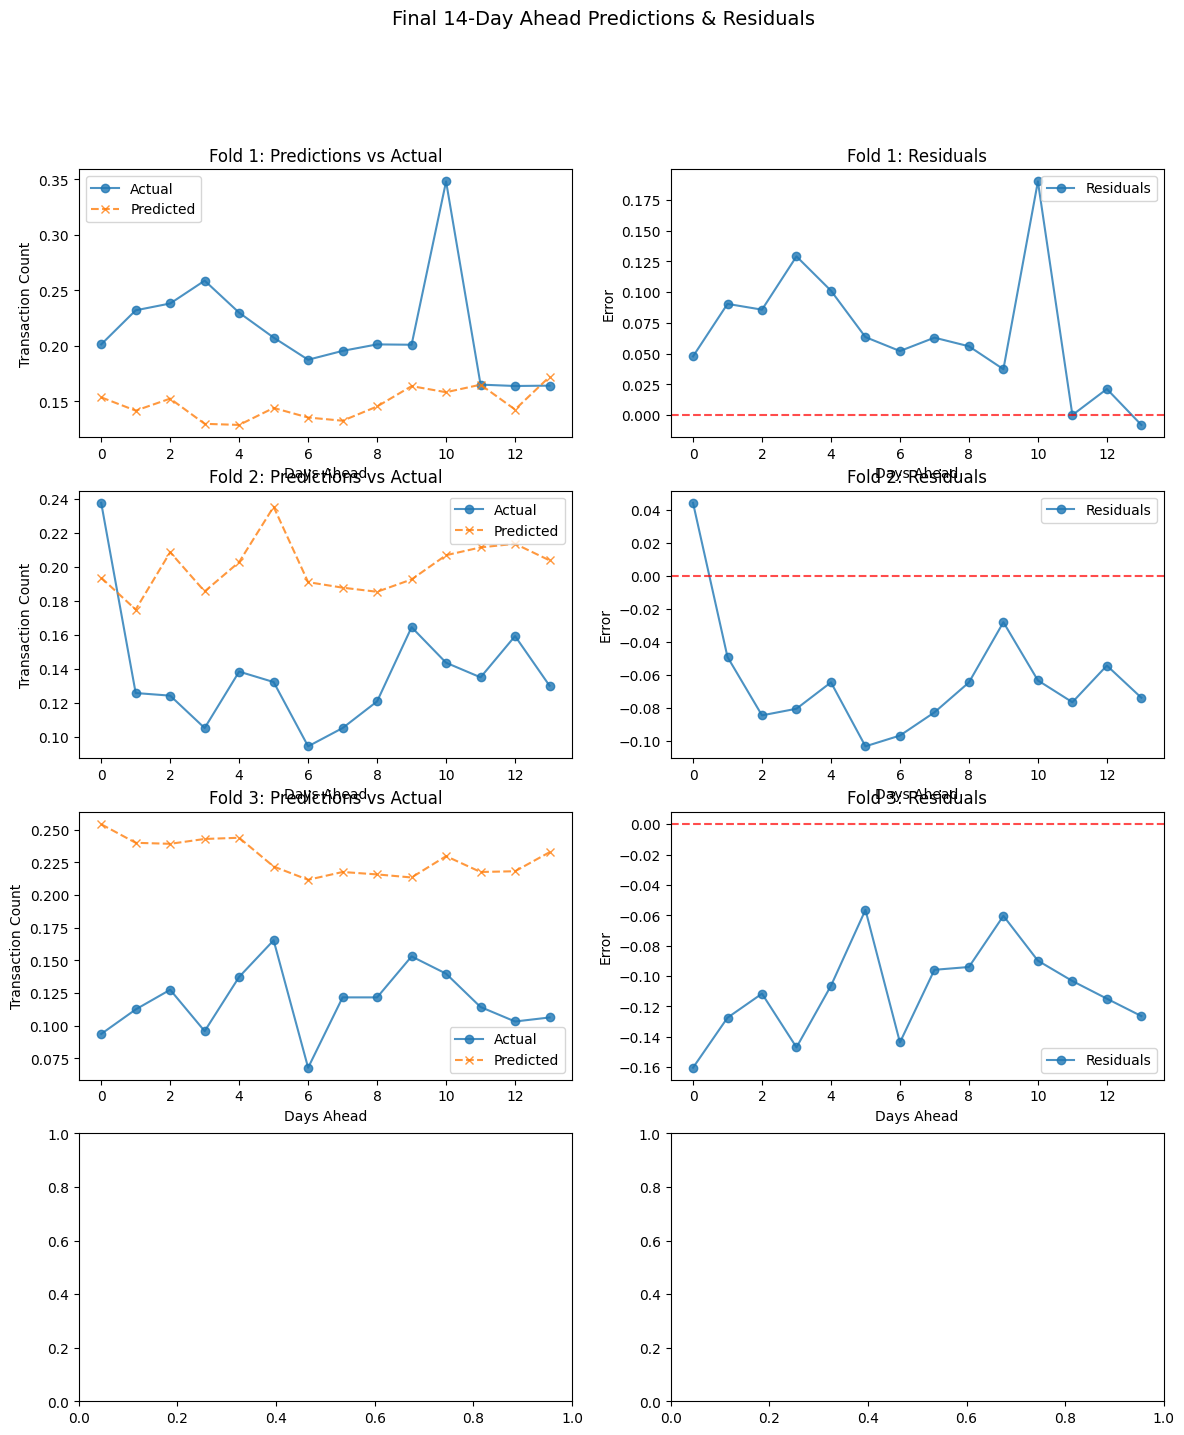

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def final_train_with_best_params(
    group_df_scaled, 
    best_params,
    pretrained_weights,
    output_dir,
    final_epochs=50,
    n_splits=4
):
    """
    Perform final training/cross-validation with the best hyperparams
    and save final metrics & model for a single product group.
    """
    # 1. Parse best_params
    lr = best_params.get("lr", 1e-4)
    dropout = best_params.get("dropout", 0.2)
    window_size = int(best_params.get("window_size", 14))
    batch_size = int(best_params.get("batch_size", 32))

    # 2. Rebuild dataset with the best window size
    dataset = TimeSeriesDataset(
        group_df_scaled,
        input_window=window_size,
        output_window=14,  # Ensure this matches the target output size
        target_col_name='transaction_count'
    )

    # 3. Cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_metrics = []

    # Create figure for predictions & residuals side by side
    fig, axes = plt.subplots(nrows=n_splits, ncols=2, figsize=(14, 4 * n_splits))
    fig.suptitle("Final 14-Day Ahead Predictions & Residuals", fontsize=14, y=0.98)

    fold = 0
    for train_idx, val_idx in tscv.split(range(len(dataset))):
        fold += 1
        print(f"=== Final Fold {fold} ===")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        num_features = group_df_scaled.shape[1]

        # Build the TCN model
        model = TCNForecastingModel(
            num_inputs=num_features,
            num_channels=[64, 64],
            kernel_size=3,
            dropout=dropout,
            output_size=14  # Ensure model predicts output_window (14)
        )

        # Load pretrained checkpoint and match layers
        checkpoint = torch.load(pretrained_weights)
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict and model_dict[k].shape == v.shape}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict=False)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Final training loop
        for epoch in range(final_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                preds = model(X_batch)
                preds = preds.view(-1, 14)  # Ensure correct shape

                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()

        # Collect predictions
        all_preds, all_targets = [], []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds = model(X_batch)
                preds = preds.view(-1, 14)  # Ensure correct shape
                all_preds.append(preds.cpu().numpy())
                all_targets.append(y_batch.cpu().numpy())

        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        # Compute metrics
        mae = mean_absolute_error(all_targets, all_preds)
        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        mape = (abs(all_targets - all_preds) / (abs(all_targets) + 1e-8)).mean() * 100
        r2 = r2_score(all_targets, all_preds)

        print(f"Fold {fold} => MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")

        fold_metrics.append({
            "Fold": fold,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "R2": r2
        })

        # Plot Predictions vs Actual & Residuals
        ax_pred = axes[fold-1, 0] if n_splits > 1 else axes[0]
        ax_res = axes[fold-1, 1] if n_splits > 1 else axes[1]

        time_steps = np.arange(14)  # Fixed 14-day ahead steps

        # Plot Predictions vs Actual
        ax_pred.plot(time_steps, all_targets[-1], label="Actual", linestyle='-', alpha=0.8)
        ax_pred.plot(time_steps, all_preds[-1], label="Predicted", linestyle='--', alpha=0.8)
        ax_pred.set_title(f"Fold {fold}: Predictions vs Actual")
        ax_pred.set_xlabel("Days Ahead")
        ax_pred.set_ylabel("Transaction Count")
        ax_pred.legend()

        # Compute residuals
        residuals = all_targets[-1] - all_preds[-1]

        # Plot Residuals
        ax_res.plot(time_steps, residuals, label="Residuals", marker='o', linestyle='-', alpha=0.8)
        ax_res.axhline(0, color='r', linestyle='--', alpha=0.7)
        ax_res.set_title(f"Fold {fold}: Residuals")
        ax_res.set_xlabel("Days Ahead")
        ax_res.set_ylabel("Error")
        ax_res.legend()

    # Summarize and save
    fold_df = pd.DataFrame(fold_metrics)
    avg_metrics = {
        "MAE": fold_df["MAE"].mean(),
        "RMSE": fold_df["RMSE"].mean(),
        "MAPE": fold_df["MAPE"].mean(),
        "R2": fold_df["R2"].mean()
    }
    print("\nFinal Fold Metrics:")
    print(fold_df)
    print("Average Metrics:", avg_metrics)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig_path = os.path.join(output_dir, "final_14day_preds_residuals.png")
    plt.savefig(fig_path)
    plt.close(fig)

    # Save metrics
    fold_df.to_csv(os.path.join(output_dir, "final_fold_metrics.csv"), index=False)
    pd.DataFrame([avg_metrics]).to_csv(os.path.join(output_dir, "final_avg_metrics.csv"), index=False)

    # Save final model
    final_model_path = os.path.join(output_dir, "final_finetuned_model.pt")
    torch.save(model.state_dict(), final_model_path)

    return fold_df, avg_metrics




for product_group in top_10_groups:
    # 1. Filter & scale group data
    group_df = data[data['product_group'] == product_group].copy()
    group_df.sort_values(["date", "product_group"], inplace=True)
    group_df = group_df.drop(columns=['date','product_group'], errors='ignore')
    
    X_group = group_df.drop(columns=['transaction_count']).values
    y_group = group_df['transaction_count'].values.reshape(-1,1)
    X_group_scaled = feature_scaler.transform(X_group)
    y_group_scaled = target_scaler.transform(y_group)

    feature_cols = [col for col in group_df.columns if col != 'transaction_count']
    group_df_scaled = pd.DataFrame(X_group_scaled, columns=feature_cols)
    group_df_scaled['transaction_count'] = y_group_scaled
    group_df_scaled.sort_index(inplace=True)

    # 2. Load best_params from CSV or memory
    from modules.utils import process_name
    sanitized_group = process_name(product_group)
    group_output_dir = os.path.join("output/top_10_product_groups/transfer_14_days_finetuned", sanitized_group)
    best_params_csv = os.path.join(group_output_dir, "best_params.csv")
    best_params_df = pd.read_csv(best_params_csv)
    best_params = best_params_df.iloc[0].to_dict()

    # 3. Call final_train_with_best_params
    final_fold_df, final_avg_metrics = final_train_with_best_params(
        group_df_scaled=group_df_scaled,
        best_params=best_params,
        pretrained_weights="pretrained_tcn.pt",
        output_dir=group_output_dir,
        final_epochs=50,
        n_splits=4
    )


In [262]:
import os
import pandas as pd

# Define the folder path
folder_path = 'output/top_10_product_groups/transfer_14_days_finetuned'

# Use os.walk to list all CSV files in the folder and subfolders
csv_files = []
for root, _, files in os.walk(folder_path):
    for file in files:
        if file.endswith('_avg_metrics.csv'):
            csv_files.append(os.path.join(root, file))

# Initialize an empty list to store the data
all_metrics = []

# Loop through each CSV file and read the data
for csv_file in csv_files:
    metrics_df = pd.read_csv(csv_file)
    all_metrics.append(metrics_df)

# Concatenate all dataframes and calculate the average across the rows
averaged_metrics = pd.concat(all_metrics).mean(axis=0)

# Save the averaged metrics to a new CSV file
output_file = 'output/top_10_product_groups/transfer_14_days_finetuned/overall_avg_metrics.csv'
averaged_metrics.to_csv(output_file, header=True)

print(f'Averaged metrics have been saved to {output_file}')


Averaged metrics have been saved to output/top_10_product_groups/transfer_14_days_finetuned/overall_avg_metrics.csv
